# Đọc Dataset

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
df = pd.read_csv("heart_disease_dataset_400.csv")

# Phân chia dữ liệu thành X và y

In [ ]:
X = df.drop('target', axis=1)
y = df['target']
print("\n Data loaded and split into X and y.")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


 Data loaded and split into X and y.
Shape of X: (400, 13)
Shape of y: (400,)


# Mã hóa cột phân loại

In [ ]:
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [ ]:
print("\nCategorical features:", categorical_features)
print("Numerical features:", numerical_features)


Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Numerical features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


In [ ]:
numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' 
)

# Chia Dataset thành tập train và test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nDataset split into training (80%) and testing (20%) sets.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Dataset split into training (80%) and testing (20%) sets.
X_train shape: (320, 13)
X_test shape: (80, 13)


# Huấn luyện mô hình

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [ ]:
best_model_name = ''
best_model_f1 = 0.0
model_performance = {}

print("\nTraining and evaluating various models...")

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) 
    model_performance[name] = {'Accuracy': accuracy, 'F1-Score': f1}

    print(f"- {name}: F1-Score = {f1:.4f}, Accuracy = {accuracy:.4f}")

    if f1 > best_model_f1:
        best_model_f1 = f1
        best_model_name = name

print(f"\n---> Best Model Selected: {best_model_name} (F1-Score: {best_model_f1:.4f})")



Training and evaluating various models...
- Logistic Regression: F1-Score = 0.6824, Accuracy = 0.6625
- SVM: F1-Score = 0.8941, Accuracy = 0.8875
- KNN: F1-Score = 0.7532, Accuracy = 0.7625
- Random Forest: F1-Score = 0.9512, Accuracy = 0.9500
- XGBoost: F1-Score = 0.9398, Accuracy = 0.9375

---> Best Model Selected: Random Forest (F1-Score: 0.9512)


c:\Program Files\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Chọn Tham Số

In [ ]:
print(f"\nPerforming GridSearchCV for {best_model_name}...")

param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'saga']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': [1, 0.1, 0.01],
        'classifier__kernel': ['rbf', 'linear']
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
}


Performing GridSearchCV for Random Forest...


In [ ]:
best_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', models[best_model_name])])

grid_search = GridSearchCV(best_model_pipeline, param_grid=param_grids[best_model_name],
                           cv=5, scoring='f1', n_jobs=-1, verbose=1)

In [ ]:
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found for {best_model_name}:")
print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters found for Random Forest:
{'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


# Đánh giá mô hình

In [ ]:
print("\nEvaluating the final tuned model on the test set.")
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)


Evaluating the final tuned model on the test set.


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        38
           1       0.97      0.93      0.95        42

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



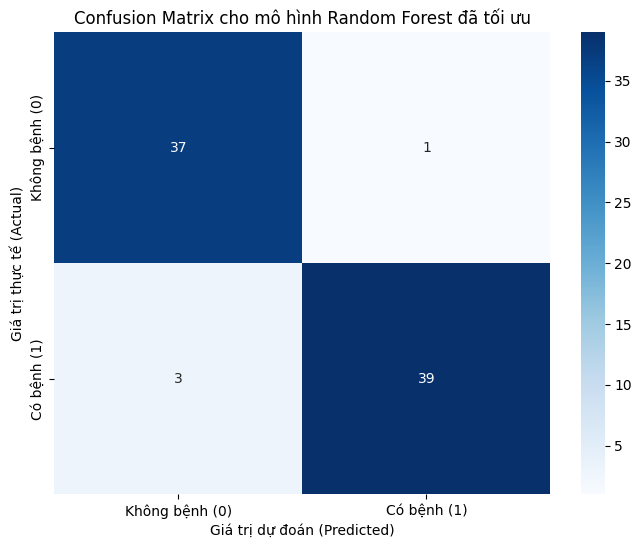


Confusion Matrix has been saved as 'confusion_matrix.png'


In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Không bệnh (0)', 'Có bệnh (1)'],
            yticklabels=['Không bệnh (0)', 'Có bệnh (1)'])
plt.title(f'Confusion Matrix cho mô hình {best_model_name} đã tối ưu')
plt.ylabel('Giá trị thực tế (Actual)')
plt.xlabel('Giá trị dự đoán (Predicted)')
plt.show()
print("\nConfusion Matrix has been saved as 'confusion_matrix.png'")

In [ ]:
import pickle

filename = 'random_forest_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(best_model, file)